# Photo Booth 
**Abstrack**
A camera with preloaded filters using opencv.
The user can interact with the webcam and apply multiple filters using keyboard input.

**Included features**
1. Color filter
2. Face focus filter
3. Portrait filter
4. Smoothing filter
5. Detail enhance filter

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import imageio
import sys

This is a sample image.

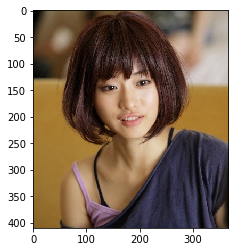

In [30]:
picture = cv2.imread('ishihara.jpg')
display(picture)
h,w,ch = picture.shape

In order to apply the filters, we need an alpha channel.
Each filters require blending between pictures to apply effects.
By calling **verify_alpha**, the frames are confirmed that they have an alpha channel.

In [31]:
# Some filters need additional alpha channel. So we add an alpha channel to frames that don't have one
def verify_alpha(frame):
    try:
        frame.shape[3] #alpha channel
    except IndexError:
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2BGRA)
    return frame

In [32]:
# function for displaying output images 
def display(frame):
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()

**1. Color filter**
This filter emphasizes the frame to a certain color (preloaded to be green). It can be used to propose color ambiance on the picture. The function acquires intensity and color value. Intensity will matter on how hard the color will be overwritten and the color value suggests the overwritting color. 

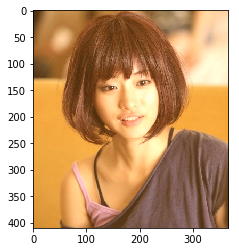

In [33]:
#sepia
display(pic_color(picture))

In [34]:
def pic_color(frame,intensity=0.7,blue=20,green=66,red=112):
    frame = verify_alpha(frame)  
    h,w,ch = frame.shape
    color_bgra = (blue,green,red,1)
    overlay = np.full((h,w,4),color_bgra, dtype = 'uint8')
    cv2.addWeighted(overlay,intensity,frame,1.0,0,frame) #blends to the frame
    frame = cv2.cvtColor(frame,cv2.COLOR_BGRA2BGR)
    return frame

**2. Face focus filter** This filter creates a camera focus effect to the user's face by blurring the background. The focusing area follows the movement of the user's face. Blurring effect is made by overlaying the
blurred frame over the face mask. Kernel variable determines the intensity of the blurring. Mask is created according to the face location which will be obtained in the main function.

In [35]:
# focus on face, blurs out the background
def pic_focus_blur(frame, kernel=9):
    kernel = (kernel,kernel)
    frame = verify_alpha(frame)
    mask = np.zeros((frame.shape[0],frame.shape[1],4), dtype='uint8')

    # determining the location of the mask
    for (x,y,w,h) in face_rects:
        radius = int(w/1.2)
        center = (int(x+w/2),int(y+h/2))
        cv2.circle(mask,center, radius,(255,255,255),-1,cv2.LINE_AA)
        break


    mask = cv2.GaussianBlur(mask,kernel,11)
    blured = cv2.GaussianBlur(frame,kernel,11)  #kernel size, border
    blended = alpha_blend(frame,blured,255-mask)
    frame = cv2.cvtColor(blended,cv2.COLOR_BGRA2BGR)
    return frame
    

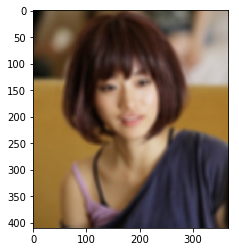

In [37]:
# blends the mask into frame
def alpha_blend(frame1,frame2,mask):
    alpha = mask/255.0 
    blended = cv2.convertScaleAbs(frame1*(1-alpha)+frame2*alpha)
    return blended
display(pic_focus_blur(picture))

**3. Portrait filter** This filter adds a painting like texture to the focus blur filter, creating a user's portrait. The effect is added by overlaying a binarized mask, which emphasizes the edges and face features.
The intensity of the filter can be toggled by kernel value.

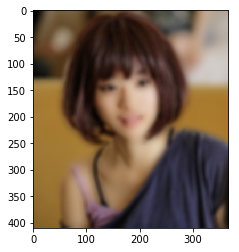

In [38]:
# portrait mode
def pic_portrait(frame, kernel = 21):
    kernel = (kernel,kernel)
    frame = verify_alpha(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 120,255,cv2.THRESH_BINARY) #binarization
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGRA)
    blured = cv2.GaussianBlur(frame,kernel,11)
    blended = alpha_blend(frame,blured,mask)
    frame = cv2.cvtColor(blended,cv2.COLOR_BGRA2BGR)
    frame = pic_focus_blur(frame)
    return frame
display(pic_portrait(picture))

**4. Smoothing filter 5. Detail enhance filter** Used opencv functions detail enhance, edgepreserving

**Main function** Webcam initiates when this function is called. It loads cascade data which will be used later in the filters and waits for the user's input. When keys z,x,c,v,b,g are pressed,
change in the webcam is shown, applying the filters immediately. When pressed q, the webcam shuts and saves the image.

In [40]:
# initiate webcam
def take_picture():
    global face_rects
    global face_cascade, eyes_cascade
    cap = cv2.VideoCapture(0)
    cur_char = -1
    prev_char = -1
    state = 0
    
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    eyes_cascade = cv2.CascadeClassifier('frontalEyes35x16.xml')
    scaling_factor= 0.5
    
    
    while(True):
        ret, frame = cap.read()
        h,w,ch = frame.shape  
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        face_rects = face_cascade.detectMultiScale(gray,1.5,5)       
        c = cv2.waitKey(1)
        if c & 0xFF == ord('q'):
            cv2.imwrite("picture.jpg", frame)
            break
        if c>-1 and c!=prev_char:
            cur_char = c
        prev_char = c
        
        if cur_char == ord('z'):
            frame = pic_focus_blur(frame.copy())
            
        elif cur_char == ord('x'):
            frame = pic_portrait(frame.copy())
            
        elif cur_char == ord('c'):
            frame = pic_color(frame.copy())
            
        elif cur_char == ord('v'):
            frame = cv2.detailEnhance(frame,sigma_s=60,sigma_r=0.3)
            
        elif cur_char == ord('b'):
            frame = cv2.edgePreservingFilter(frame,1,sigma_s=10,sigma_r=0.5)
        cv2.imshow('frame',frame)
    cap.release()
    cv2.destroyAllWindows()
    return frame

In [41]:
picture = take_picture()